In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

import time as time

In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f'device:{device}')

device:cuda:1


In [3]:
class NN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction = 'mean')
        self.layers = layers

        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])


        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain = 1.0)
            nn.init.zeros_(self.linears[i].bias.data)



    def forward(self,x,y,t):
        a = torch.cat([x,y,t], dim = 1)

        for i in range(len(self.layers)-2):
            L = self.linears[i](a)
            a = self.activation(L)

        b = self.linears[-1](a)

        return b


In [4]:
layers = np.array([3,128,128,128,128,1])
net_phi = NN(layers).to(device)
net_mu = NN(layers).to(device)

In [5]:
# Define LHS

def lhs(n:int, d:int, low: np.ndarray, high: np.ndarray) -> np.ndarray:

    low = np.asarray(low).reshape(1,d)
    high = np.asarray(high).reshape(1,d)

    m = np.random.rand(n,d)

    a = np.linspace(0,1,n, endpoint = False).reshape(n,1)
    b = np.linspace(1/n,1,n).reshape(n,1)

    pts =  a + m*(b-a)

    for j in range(d):
        np.random.shuffle(pts[:,j])

    return low+(high-low)*pts


In [6]:
# Create Collocation Points

X = lhs(n = 10000, d=3, low=np.array([-1,-1,0]), high = np.array([1,1,1]))

x_f = (X[:,[0]])
x_f = torch.tensor(x_f, dtype = torch.float32, device = device, requires_grad=True)

y_f = (X[:,[1]])
y_f = torch.tensor(y_f, dtype = torch.float32, device = device, requires_grad=True)


t_f = (X[:,[2]])
t_f = torch.tensor(t_f, dtype = torch.float32, device = device, requires_grad=True)



In [23]:
def bc_loss():
    x_l = -torch.ones(200,1)
    x_l = torch.tensor(x_l, dtype = torch.float32, device = device, requires_grad=True)


    x_r = torch.ones(200,1)
    x_r = torch.tensor(x_r, dtype = torch.float32, device = device, requires_grad=True)

    y_l = -torch.ones(200,1)
    y_l = torch.tensor(y_l, dtype = torch.float32, device = device, requires_grad=True)


    y_r = torch.ones(200,1)
    y_r = torch.tensor(y_r, dtype = torch.float32, device = device, requires_grad=True)


    t = torch.rand(200,1)
    t = torch.tensor(t, dtype = torch.float32, device = device)

    x = torch.linspace(-1,1,200).view(-1,1)
    x = torch.tensor(x, dtype = torch.float32, device = device)

    y = torch.linspace(-1,1,200).view(-1,1)
    y = torch.tensor(y, dtype = torch.float32, device = device)


    phi_x_left = net_phi(x_l,y,t)
    phi_x_right = net_phi(x_r,y, t)

    phi_y_left = net_phi(x,y_l,t)
    phi_y_right = net_phi(x,y_r, t)

    phi_l_x_der = torch.autograd.grad(phi_x_left, x_l, torch.ones_like(phi_x_left), create_graph=True)[0]
    phi_r_x_der = torch.autograd.grad(phi_x_right, x_r, torch.ones_like(phi_x_right), create_graph=True)[0]

    phi_l_y_der = torch.autograd.grad(phi_y_left, y_l, torch.ones_like(phi_y_left), create_graph=True)[0]
    phi_r_y_der = torch.autograd.grad(phi_y_right, y_r, torch.ones_like(phi_y_right), create_graph=True)[0]

    res_bc_1 = phi_x_left - phi_x_right
    loss_bc_1 = torch.mean(res_bc_1 ** 2)

    res_bc_2 = phi_y_left - phi_y_right
    loss_bc_2 = torch.mean(res_bc_2 ** 2)

    res_bc_3 = phi_l_x_der - phi_r_x_der
    loss_bc_3 = torch.mean(res_bc_3 ** 2)

    res_bc_4 = phi_l_y_der - phi_r_y_der
    loss_bc_4 = torch.mean(res_bc_4 ** 2)


    loss_bc = loss_bc_1 + loss_bc_2 + loss_bc_3 + loss_bc_4


    return loss_bc

In [56]:
def ic_loss():
    # x = torch.linspace(-1,1,200).view(-1,1)
    # x = torch.tensor(x, dtype = torch.float32, device = device)

    # y = torch.linspace(-1,1,200).view(-1,1)
    # y = torch.tensor(y, dtype = torch.float32, device = device)

    x = -1 + 2*torch.rand(200,1, dtype = torch.float32, device=device)
    y = -1 + 2*torch.rand(200,1, dtype = torch.float32, device=device)


    t = torch.zeros(200,1)
    t = torch.tensor(t, dtype = torch.float32, device = device)


    r = 0.4

    e = 0.05

    R_1 = torch.sqrt((x-0.7*r)**2  + y**2)
    R_2 = torch.sqrt((x+0.7*r)**2  + y**2)


    phi = net_phi(x,y,t)

    d = torch.maximum(torch.tanh((r-R_1)/(2*e)), torch.tanh((r-R_2)/(2*e)))

    res_ic = phi - d

    loss_ic = torch.mean(res_ic**2)

    return loss_ic

In [57]:
def pde_loss(x,y,t):
    lam = 1.0
    
    e = 0.05
    
    
    phi = net_phi(x,y,t)

    phi_t = torch.autograd.grad(phi, t, torch.ones_like(phi), create_graph=True)[0]
    phi_x = torch.autograd.grad(phi, x, torch.ones_like(phi), create_graph=True)[0]
    phi_x_x = torch.autograd.grad(phi_x, x, torch.ones_like(phi_x), create_graph=True)[0]
    phi_y = torch.autograd.grad(phi, y, torch.ones_like(phi), create_graph=True)[0]
    phi_y_y = torch.autograd.grad(phi_y, y, torch.ones_like(phi_y), create_graph=True)[0]


    mu = net_mu(x,y,t)
    mu_x = torch.autograd.grad(mu, x, torch.ones_like(mu), create_graph=True)[0]
    mu_x_x = torch.autograd.grad(mu_x, x, torch.ones_like(mu_x), create_graph=True)[0]
    mu_y = torch.autograd.grad(mu, y, torch.ones_like(mu), create_graph=True)[0]
    mu_y_y = torch.autograd.grad(mu_y, y, torch.ones_like(mu_y), create_graph=True)[0]


    res_mu = mu - (-e**2 *(phi_x_x + phi_y_y) + phi**3 - phi)
    loss_mu = torch.mean(res_mu**2)


    res_pde = phi_t - lam*(mu_x_x + mu_y_y)
    pde_loss = torch.mean(res_pde**2)


    loss_pde = loss_mu + pde_loss


    return loss_pde

    

In [66]:
def add_losses():
    loss_bc = bc_loss()
    loss_ic = ic_loss()
    loss_pde = pde_loss(x_f, y_f, t_f)


    total_loss = loss_bc + loss_ic + loss_pde


    return total_loss
    

In [67]:
optimizer_phi = torch.optim.Adam(net_phi.parameters(), lr = 0.001)
optimizer_mu = torch.optim.Adam(net_mu.parameters(), lr = 0.001)

In [68]:
torch.manual_seed(42)

In [69]:
if device.type == 'cuda':
    torch.cuda.reset_peak_memory_stats(device)

In [70]:
start_time = time.time()

num_epochs = 20000

total_loss_list = []

for epoch in range(num_epochs):
    optimizer_phi.zero_grad()
    optimizer_mu.zero_grad()
    

    total_loss = add_losses()

    total_loss.backward()
    

    optimizer_phi.step()
    optimizer_mu.step()
    

    
    total_loss_list.append(total_loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}:  total loss={total_loss.item():.3e}")

    
end_time = time.time()

print(f'Total Training Time: {(end_time - start_time): .4f}seconds')

/tmp/ipykernel_919669/583930700.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_l = torch.tensor(x_l, dtype = torch.float32, device = device, requires_grad=True)
/tmp/ipykernel_919669/583930700.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_r = torch.tensor(x_r, dtype = torch.float32, device = device, requires_grad=True)
/tmp/ipykernel_919669/583930700.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_l = torch.tensor(y_l, dtype = torch.float32, device = device, requires_grad=True)
/tmp/ipykernel_919669/583930700.py:14: 

Epoch 0:  total loss=9.925e-04
Epoch 500:  total loss=6.009e-04
Epoch 1000:  total loss=5.435e-04
Epoch 1500:  total loss=5.599e-04
Epoch 2000:  total loss=8.747e-04
Epoch 2500:  total loss=3.411e-04
Epoch 3000:  total loss=2.727e-04
Epoch 3500:  total loss=3.796e-04
Epoch 4000:  total loss=3.053e-04
Epoch 4500:  total loss=4.936e-04
Epoch 5000:  total loss=2.392e-04
Epoch 5500:  total loss=2.685e-04
Epoch 6000:  total loss=2.755e-04
Epoch 6500:  total loss=1.752e-04
Epoch 7000:  total loss=1.686e-04
Epoch 7500:  total loss=1.551e-04
Epoch 8000:  total loss=1.644e-04
Epoch 8500:  total loss=1.633e-04
Epoch 9000:  total loss=1.622e-04
Epoch 9500:  total loss=2.654e-04
Epoch 10000:  total loss=1.920e-04
Epoch 10500:  total loss=1.524e-04
Epoch 11000:  total loss=1.739e-04
Epoch 11500:  total loss=1.936e-04
Epoch 12000:  total loss=3.466e-04
Epoch 12500:  total loss=1.540e-04
Epoch 13000:  total loss=1.629e-04
Epoch 13500:  total loss=1.737e-04
Epoch 14000:  total loss=1.346e-04
Epoch 145

In [71]:
params = list(net_phi.parameters()) + list(net_mu.parameters())


optimizer_lbfgs = torch.optim.LBFGS(
    params,
    lr=1.0,                  # common starting point
    max_iter=5000,           # total iterations inside .step()
    max_eval=5000,
    history_size=100,
    line_search_fn="strong_wolfe"
)


lbfgs_iter = 0

def closure():
    global lbfgs_iter

    optimizer_lbfgs.zero_grad(set_to_none=True)

    loss = add_losses()

    loss.backward()

    if lbfgs_iter % 50 == 0:
        print(f"[LBFGS iter {lbfgs_iter}] loss = {loss.item():.3e}")
    lbfgs_iter += 1

    return loss


print("Starting LBFGS fine-tuning...")
optimizer_lbfgs.step(closure)
print("LBFGS done.")

Starting LBFGS fine-tuning...
[LBFGS iter 0] loss = 2.262e-04


/tmp/ipykernel_919669/583930700.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_l = torch.tensor(x_l, dtype = torch.float32, device = device, requires_grad=True)
/tmp/ipykernel_919669/583930700.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_r = torch.tensor(x_r, dtype = torch.float32, device = device, requires_grad=True)
/tmp/ipykernel_919669/583930700.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_l = torch.tensor(y_l, dtype = torch.float32, device = device, requires_grad=True)
/tmp/ipykernel_919669/583930700.py:14: 

LBFGS done.


In [72]:
# Memory usage after training

if device.type == 'cuda':
    peak_mem = torch.cuda.max_memory_allocated(device)
    print(f'Peak GPU Memory Usage: {peak_mem / 1e6: .2f} MB')

Peak GPU Memory Usage:  1519.47 MB


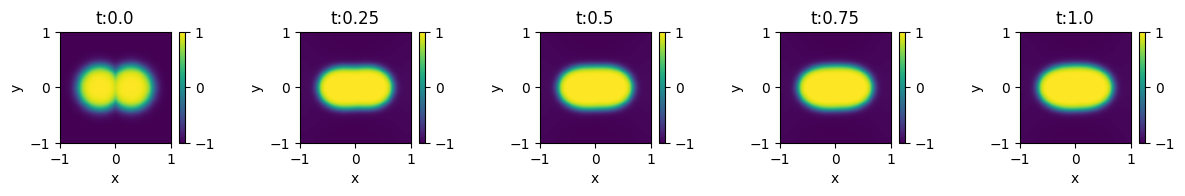

In [73]:
t_list = [0.0, 0.25, 0.50, 0.75, 1.0]

x = np.linspace(-1,1,100)
y = np.linspace(-1,1,100)

X,Y = np.meshgrid(x,y, indexing = 'xy')

xy = np.stack([X.ravel(), Y.ravel()], axis = 1)

x_t = torch.tensor(xy[:,[0]], dtype = torch.float32, device = device)
y_t = torch.tensor(xy[:,[1]], dtype = torch.float32, device = device)

net_phi.eval()

fig, axes = plt.subplots(1,5, figsize=(12, 3), constrained_layout = True)


with torch.no_grad():
    for ax, tval in zip(axes, t_list):
        t_t = torch.full_like(x_t, float(tval))

        phi_pred = net_phi(x_t, y_t, t_t).detach().cpu().numpy().reshape(100,100)

        im = ax.imshow(phi_pred, extent = [-1,1,-1,1], origin = 'lower', vmin = -1, vmax = 1, aspect = 'equal')

        ax.set_title(f't:{tval}')
        ax.set_xlabel('x')
        ax.set_ylabel('y')

        plt.colorbar(im, ax = ax, fraction = 0.05, pad = 0.04)

plt.show()




